In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set style for visualizations
plt.style.use('default')  # or try 'classic'
sns.set_theme()

In [6]:
df = pd.read_csv('heart_disease_data.csv')

In [7]:
print("Dataset Shape:", df.shape)
print("\nFeature Information:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (303, 14)

Feature Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None

Basic Statistics:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  

## Data Visualizations

In [8]:
plt.figure(figsize=(20, 12))

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

Text(0.5, 1.0, 'Age Distribution by Target')

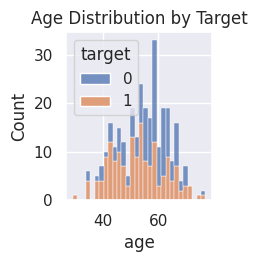

In [9]:
# Age Distribution
plt.subplot(2, 3, 1)
sns.histplot(data=df, x='age', hue='target', multiple="stack", bins=30)
plt.title('Age Distribution by Target')

Text(0.5, 0, 'Sex (0=Female, 1=Male)')

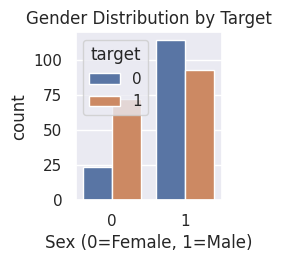

In [30]:
# Gender Distribution
plt.subplot(2, 3, 2)
sns.countplot(data=df, x='sex', hue='target')
plt.title('Gender Distribution by Target')
plt.xlabel('Sex (0=Female, 1=Male)')

Text(0.5, 1.0, 'Chest Pain Type Distribution by Target')

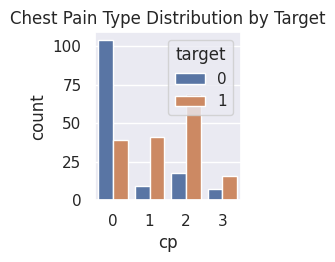

In [31]:
# Chest Pain Type Distribution
plt.subplot(2, 3, 3)
sns.countplot(data=df, x='cp', hue='target')
plt.title('Chest Pain Type Distribution by Target')

Text(0.5, 1.0, 'Cholesterol vs Age')

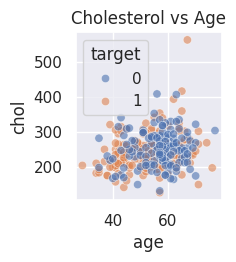

In [29]:
# Cholesterol vs Age
plt.subplot(2, 3, 4)
sns.scatterplot(data=df, x='age', y='chol', hue='target', alpha=0.6)
plt.title('Cholesterol vs Age')

Text(0.5, 1.0, 'Max Heart Rate vs Age')

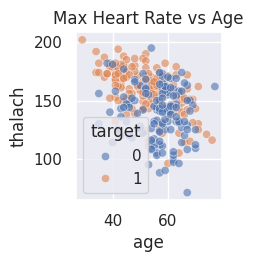

In [28]:
# Max Heart Rate vs Age
plt.subplot(2, 3, 5)
sns.scatterplot(data=df, x='age', y='thalach', hue='target', alpha=0.6)
plt.title('Max Heart Rate vs Age')

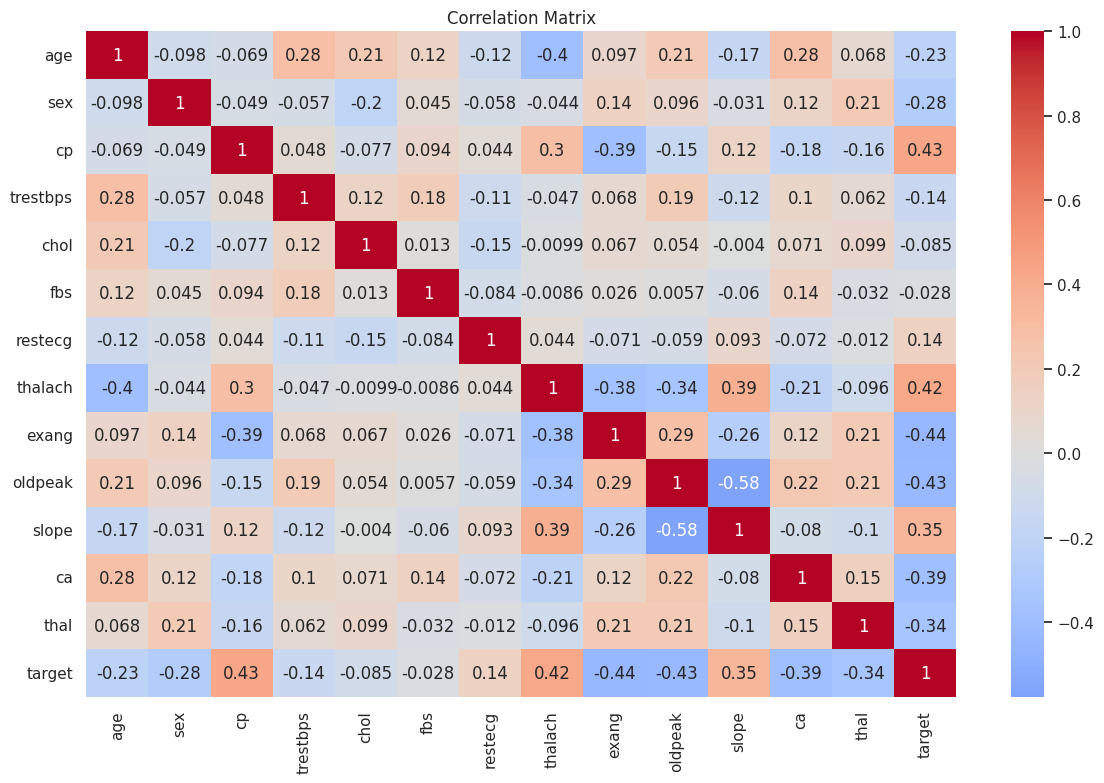

In [14]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()

## Feature Engineering and Preprocessing

In [15]:
# Create age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 100], labels=['<40', '40-50', '50-60', '>60'])

# Create blood pressure categories
df['bp_category'] = pd.cut(df['trestbps'], 
                          bins=[0, 120, 140, 180, 300], 
                          labels=['Normal', 'Prehypertension', 'Stage 1', 'Stage 2'])

In [16]:
X = df.drop(['target', 'age_group', 'bp_category'], axis=1)
y = df['target']

In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Development and Evaluation

In [18]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

In [19]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Store results
    results[name] = {
        'accuracy': model.score(X_test_scaled, y_test),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Calculate ROC curve
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    results[name]['roc_auc'] = auc(fpr, tpr)
    results[name]['fpr'] = fpr
    results[name]['tpr'] = tpr

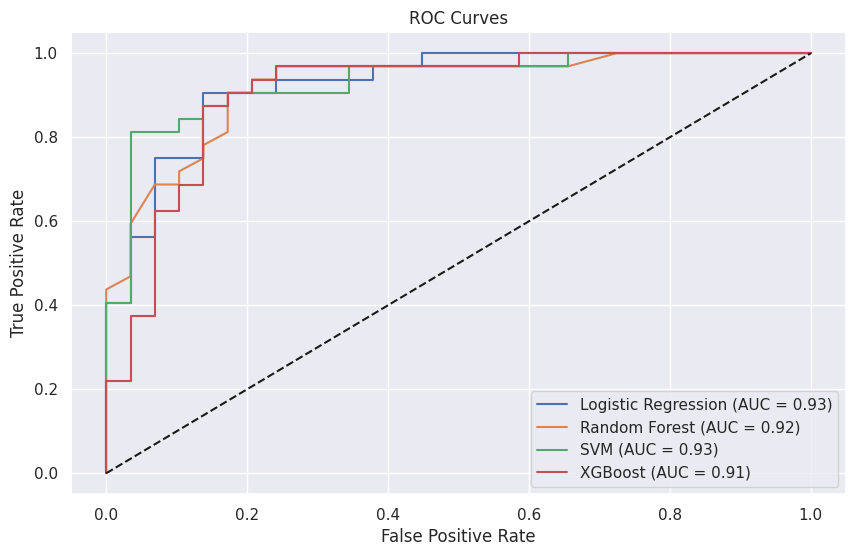

In [20]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
for name in models.keys():
    plt.plot(results[name]['fpr'], 
             results[name]['tpr'], 
             label=f'{name} (AUC = {results[name]["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

## Feature Importance Analysis (using Random Forest)

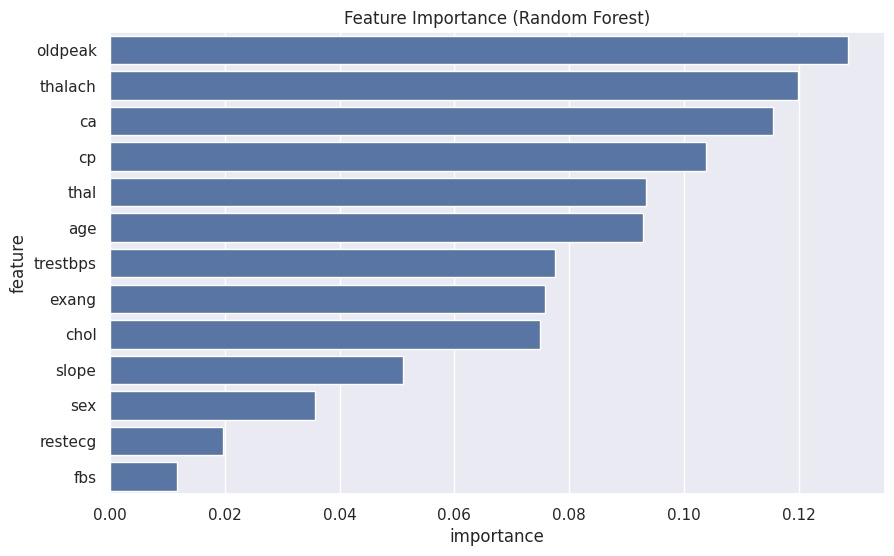

In [21]:
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance (Random Forest)')
plt.show()

## Model Fine-tuning (for the best performing model)

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                         param_grid=param_grid,
                         cv=5,
                         scoring='accuracy',
                         n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

print("\nBest Random Forest Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-validation Score: 0.8099489795918368


## Final Model Evaluation


Final Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



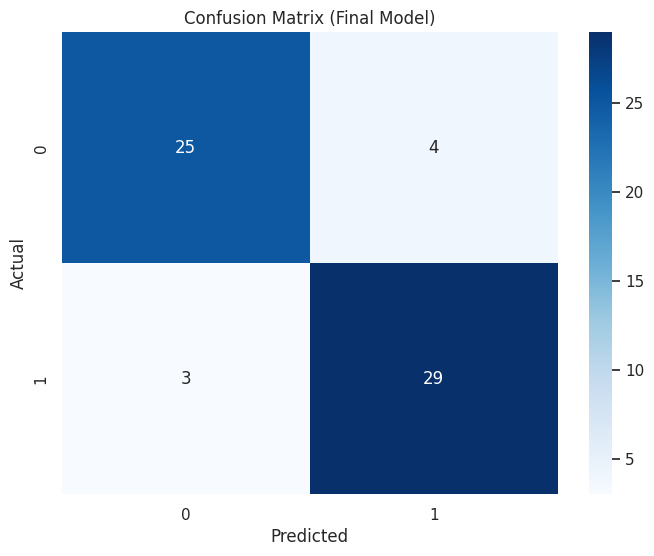

In [23]:
best_model = grid_search.best_estimator_
final_predictions = best_model.predict(X_test_scaled)

print("\nFinal Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, final_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, final_predictions), 
            annot=True, 
            fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix (Final Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Additional Analysis: Age Group Analysis

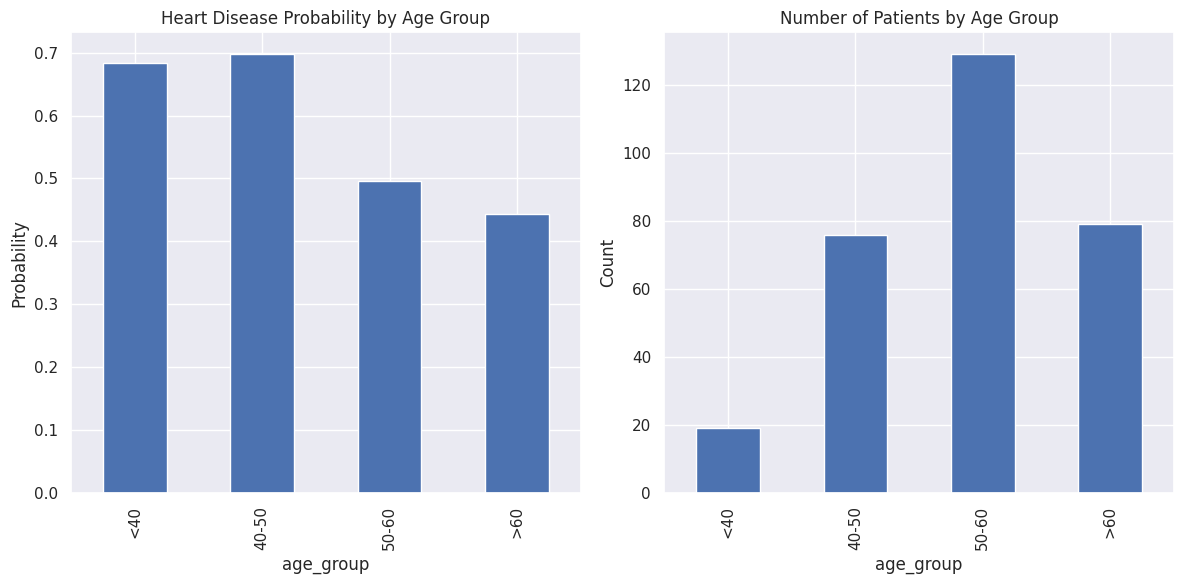

In [32]:
plt.figure(figsize=(12, 6))
age_group_analysis = df.groupby('age_group')['target'].mean()
age_group_counts = df.groupby('age_group').size()

plt.subplot(1, 2, 1)
age_group_analysis.plot(kind='bar')
plt.title('Heart Disease Probability by Age Group')
plt.ylabel('Probability')

plt.subplot(1, 2, 2)
age_group_counts.plot(kind='bar')
plt.title('Number of Patients by Age Group')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [33]:
# Summary dataframe of model performances
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'ROC AUC': [results[model]['roc_auc'] for model in results]
})

print("\nModel Comparison:")
print(model_comparison.sort_values('Accuracy', ascending=False))


Model Comparison:
                 Model  Accuracy   ROC AUC
2                  SVM  0.868852  0.931034
0  Logistic Regression  0.852459  0.926724
1        Random Forest  0.836066  0.922414
3              XGBoost  0.819672  0.907328
